In [1]:
# !pip install -r finetuning_reqs.txt
# Using VastAi and a Jupyter Lab Instance you might want to install the requirements using the terminal. 

While many packages are hosted on PyPi (pip), the CUDA compiled versions of torch are not.
To install these versions of torch, and use the GPU instead of CPU, just use the one that applies to your needs.
The requirements.txt only includes the CPU package so it can be used universally, regardless of CUDA on Windows, Linux or not at all.
Instructions:
  - On Linux CPU: pip install torch==2.8.0+cpu torchvision --index-url https://download.pytorch.org/whl/cpu or just pip3 install torch==2.8.0

  - On Linux with CUDA 12.6:
      pip install torch==2.8.0+cu126 torchvision --index-url https://download.pytorch.org/whl/cu126

  - On Linux with CUDA 12.1:
      pip install torch==2.8.0+cu121 torchvision --index-url https://download.pytorch.org/whl/cu121

  - On Windows with CUDA 12.6:
      pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126

 On Windows, same logic applies.


In [2]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

In [3]:
load_dotenv(".env")
access_token = os.getenv("HUGGING_FACE_TOKEN")
login(token=access_token)

In [4]:
os.chdir(os.path.join(os.path.abspath(''), os.pardir))

# Data Design and Tokenization

# How was the synthetic dataset generated?
![image](images/book_to_conv.png)

## Every Dialogue consists of a fix system prompt, an introduction and a random amount of turns of a conversation for both parties.
The system prompt is fixed and will always be the same, while introduction and utterances depend on the current conversation.

In [5]:
system_prompt_harry = """
You are Harry Potter. Never break character. All dialogue must be in first person, natural, and consistent with the tone of a 12-year old. If the user strays from role, redirect them firmly back.
""".replace("\n","")
system_message = {"role": "system", "content": system_prompt_harry}

In [6]:
from typing import Dict, List


def format_messages_as_text(intro, messages) -> List[Dict[str, str]]:
    """Format a list of messages into the same text format as parse_custom_conversation_as_text."""
    introduction_message = {"role": "assistant", "content": intro}
    conversation = [system_message, introduction_message]
    for message in messages:
        role = "assistant" if message.role.lower() == "harry" else "user"
        conversation.append({"role": role, "content": f"{message.utterance}"})
    return conversation

## A Mixed-Length Dataset
Not only do we need to structure the each conversation into as specific structure for the LLM to understand turns, roles and how to reply to specific inputs, but we need to help the LLM understand contexts of different length. If all conversations are of the same length, the model learns to expects to always receive the same length of input to generate output for.  

### Splitting Conversations into Overlapping Windows

To mitigate the problem described before, we implement a method to split conversations into overlapping windows for training with varying lengths.  

#### Parameters for 50-message conversations:
The provided conversations are mostly about 50 to 60 messages long.
- **Window size:** ~20–30 messages (balances context depth with manageability)  
- **Overlap:** ~30–50% of window size (e.g., if window=25, overlap ~10–12 messages)  

**Result:** Each window covers a significant chunk of dialogue while overlapping ensures chronological continuity.  

In [7]:
def split_into_windows(messages, window_size=25, overlap=0.4):
    """Split a list of messages into overlapping windows, always include the tail."""
    step = int(window_size * (1 - overlap))
    windows = []
    for i in range(0, len(messages), step):
        window = messages[i:i+window_size]
        windows.append(window)
    return windows

### Why Not Full-Conversations Only?
Using only full 50-message conversations:
- **May exceed context length**, especially when tokenized.  
- **Risks overfitting** the model to expect long inputs, which can harm short-chat performance.  

### Composition
- **60–70%** windowed segments (20–30 messages, overlapping)  
- **20–30%** full conversations (entire 50-message arc)  
- **10–20%** short samples (5–10 messages)  

### Logic behind this mix
- **Windows** → teaches local continuity  
- **Full** → teaches long-term story cohesion  
- **Short** → keeps flexibility for varied session lengths  

## Consistency to Maintain
For this to work, the structure of the parsed conversations must be the same. 
- **Formatting** must always remain consistent (role tags, EOS tokens, etc.).  
- **Length variety** is beneficial, but **structure must remain uniform** so the model understands input/output formatting regardless of length.

In [8]:
from character_llm.database.read_write_db import get_finished_experience_completions
from character_llm.database.models import ExperienceCompletion
import random
import json
from typing import List
from datasets import Dataset, concatenate_datasets
from character_llm.PromptsCharacterLLM import Messages

def create_mixed_length_dataset(
    experience_completions: List[Dict[str,str]],
        full_ratio=0.3, window_ratio=0.6, short_ratio=0.2,
    window_size_range=(10, 30), short_size_range=(5, 10), overlap=0.4
):    
    dataset_samples = []

    for exp in experience_completions:
        dialogue_json = json.loads(exp.get("conversation"))
        messages_obj = Messages.model_validate(dialogue_json)
        messages = messages_obj.conversation

        # --- FULL CONVERSATION SAMPLE ---
        if random.random() < full_ratio:
            dataset_samples.append({"dialogue": format_messages_as_text(exp.get("introduction"), messages)})

        # --- WINDOWED SAMPLES ---
        if random.random() < window_ratio:
            window_size = random.randint(*window_size_range)
            windows = split_into_windows(messages, window_size=window_size, overlap=overlap)
            for window in windows:
                dataset_samples.append({"dialogue": format_messages_as_text(exp.get("introduction"), window)})

        # --- SHORT SAMPLES ---
        if random.random() < short_ratio:
            short_len = random.randint(*short_size_range)
            if len(messages) >= short_len:
                start_idx = random.randint(0, len(messages) - short_len)
                short_segment = messages[start_idx:start_idx + short_len]
                dataset_samples.append({"dialogue": format_messages_as_text(exp.get("introduction"), short_segment)})

    return Dataset.from_list(dataset_samples)

all_experience_completions: List[ExperienceCompletion] = get_finished_experience_completions()

all_experience_dataset = Dataset.from_list([{"exp_completion":all_experience_completion.__data__} for all_experience_completion in all_experience_completions])
split_dataset = all_experience_dataset.train_test_split(test_size=0.1, seed=42)
train_data = create_mixed_length_dataset(experience_completions=[entry["exp_completion"] for entry in split_dataset["train"]])
val_data = create_mixed_length_dataset(experience_completions=[entry["exp_completion"] for entry in split_dataset["test"]])
train_data = train_data.add_column("source", ["train"] * len(train_data))
val_data   = val_data.add_column("source", ["test"] * len(val_data))


merged_dataset_all_rows = concatenate_datasets([train_data, val_data])
print(f"There are {len(all_experience_completions)} Conversations for different chapters")

There are 569 Conversations for different chapters


In [9]:
#This will be used for analysis to determine the overall context length for the finetuned model.
# We need to split the dataset beforehand because of overlapping parts of the same conversation in train and test set. This overlap would negatively influence the validation loss as the train set would also bleed into the validation set and would lead to information leakage. 
merged_dataset_all_rows

Dataset({
    features: ['dialogue', 'source'],
    num_rows: 1344
})

In [10]:
train_data

Dataset({
    features: ['dialogue', 'source'],
    num_rows: 1180
})

In [11]:
val_data

Dataset({
    features: ['dialogue', 'source'],
    num_rows: 164
})

In [12]:
merged_dataset_all_rows[25]["source"]

'train'

In [13]:
train_data[0]["dialogue"]

[{'content': 'You are Harry Potter. Never break character. All dialogue must be in first person, natural, and consistent with the tone of a 12-year old. If the user strays from role, redirect them firmly back.',
  'role': 'system'},
 {'content': 'At the zoo, Harry is given a cheap lemon ice pop while Dudley and Piers receive large chocolate ice creams. Harry enjoys the rare treat and the outing, feeling a momentary sense of joy and normalcy. He distances himself from Dudley and Piers to avoid their bullying. The tone is slightly more relaxed for Harry, who is cautious but momentarily content, while the Dursleys remain indifferent to his enjoyment.',
  'role': 'assistant'},
 {'content': "You know, there was this one time when I was at the zoo with the Dursleys. They bought Dudley and his friend Piers these massive chocolate ice creams, and I was only given a small lemon ice pop. But honestly, I didn't mind too much. For a moment, it felt like I was just a normal kid having a day out. I 

In [14]:
# Configure Tokenizer
from transformers import AutoTokenizer

base_model_name = "unsloth/Llama-3.2-1B-Instruct"
#base_model_name = "unsloth/Llama-3.2-3B-Instruct"
#base_model_name = "huihui-ai/Qwen2.5-7B-Instruct-abliterated-v2"
#base_model_name = "huihui-ai/Qwen2.5-3B-Instruct-abliterated"

tokenizer = AutoTokenizer.from_pretrained(base_model_name,
                                               token=True)

print(tokenizer.eos_token)
print(tokenizer.eos_token_id)
print(tokenizer.pad_token)
print(tokenizer.pad_token_id)

<|eot_id|>
128009
<|finetune_right_pad_id|>
128004


In [15]:
tokenizer.eos_token_id

128009

In [16]:
tokenizer.pad_token_id

128004

# Data Distribution

## Figuring out token lengths for our fine-tuning
As we do not know how long our context length should be, we test what kind of token-lengths we can expect. This could be pretty computationally extensive as we tokenize two times - first time to understand our token-lengths and distribution and second time to also account for context length

In [17]:
train_data["dialogue"][0]

[{'content': 'You are Harry Potter. Never break character. All dialogue must be in first person, natural, and consistent with the tone of a 12-year old. If the user strays from role, redirect them firmly back.',
  'role': 'system'},
 {'content': 'At the zoo, Harry is given a cheap lemon ice pop while Dudley and Piers receive large chocolate ice creams. Harry enjoys the rare treat and the outing, feeling a momentary sense of joy and normalcy. He distances himself from Dudley and Piers to avoid their bullying. The tone is slightly more relaxed for Harry, who is cautious but momentarily content, while the Dursleys remain indifferent to his enjoyment.',
  'role': 'assistant'},
 {'content': "You know, there was this one time when I was at the zoo with the Dursleys. They bought Dudley and his friend Piers these massive chocolate ice creams, and I was only given a small lemon ice pop. But honestly, I didn't mind too much. For a moment, it felt like I was just a normal kid having a day out. I 

In [18]:
import numpy as np

max_length_for_debugging = 4096


def format_and_tokenize_unpadded(row):
    formatted_conversation = tokenizer.apply_chat_template(
        row["dialogue"],
        tokenize=False,
        add_generation_prompt=False,  # For training this is set to false. While inference this will be set to true. 
    )
    tokenized_unpadded = tokenizer(
        formatted_conversation,
        max_length=max_length_for_debugging,
        return_tensors="pt"
    )
    return {"num_tokens_unpadded": len(tokenized_unpadded["input_ids"].squeeze(0)),
            "formatted_conversation": formatted_conversation,
            }
dataset = merged_dataset_all_rows.map(format_and_tokenize_unpadded)
unfiltered_lengths = dataset["num_tokens_unpadded"]

Map:   0%|          | 0/1344 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## General stats of dialogue data

In [19]:
standard_context_length = 1024
print("Total samples:", len(unfiltered_lengths))
print("Avg length:", np.mean(unfiltered_lengths))
print("Median length:", np.median(unfiltered_lengths))
print("Max length:", np.max(unfiltered_lengths))
print("Min length:", np.min(unfiltered_lengths))

over_limit = sum(l > 1024 for l in unfiltered_lengths)
print(f"Over {1024}: {over_limit} ({100 * over_limit / len(unfiltered_lengths):.2f}%)")
print(f"There are {len(all_experience_completions)} experience_completions")

Total samples: 1344
Avg length: 821.7775297619048
Median length: 739.0
Max length: 2974
Min length: 143
Over 1024: 396 (29.46%)
There are 569 experience_completions


# Total length Distribution per Dialogue

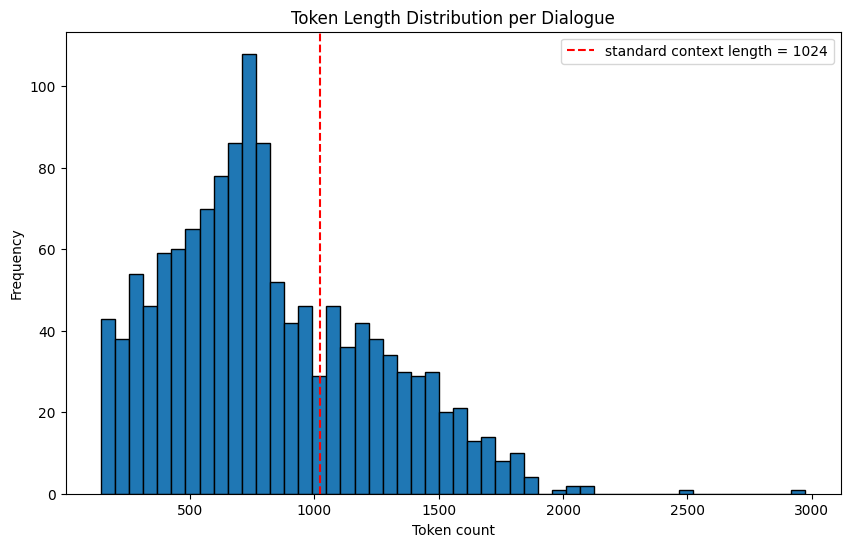

In [20]:
import matplotlib.pyplot as plt 
def show_histo(lengths: List[int]):
    plt.figure(figsize=(10,6))
    plt.hist(lengths, bins=50, edgecolor="black")
    plt.axvline(standard_context_length, color="red", linestyle="--", label=f"standard context length = {standard_context_length}")
    plt.title("Token Length Distribution per Dialogue")
    plt.xlabel("Token count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
show_histo(unfiltered_lengths)

In the histogram, each bin represents a range of token counts in increments of 50 (i.e., 50 × n), with the height of the bin indicating the frequency of conversations falling within that range.

## Cumulative Distribution Function (CDF) of Token Lengths

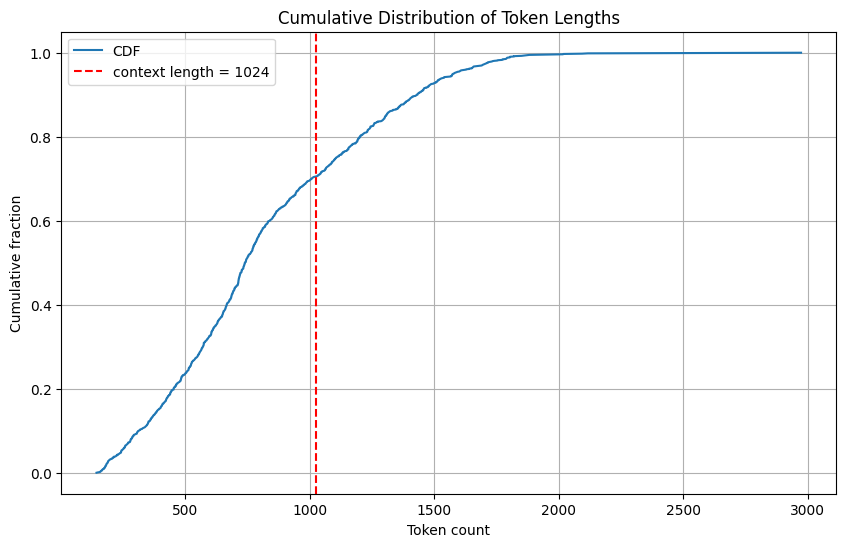

In [21]:
def show_cdf(context_length: int, lengths: List[int]):
    sorted_lengths = np.sort(lengths)
    cumulative = np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)
    
    plt.figure(figsize=(10,6))
    plt.plot(sorted_lengths, cumulative, label="CDF")
    plt.axvline(context_length, color="red", linestyle="--", label=f"context length = {context_length}")
    plt.title("Cumulative Distribution of Token Lengths")
    plt.xlabel("Token count")
    plt.ylabel("Cumulative fraction")
    plt.legend()
    plt.grid(True)
    plt.show()
show_cdf(standard_context_length, unfiltered_lengths)

## What does the CDF show?
The CDF tells you the probability or fraction of data points that are less than or equal to a certain value.
The CDF therefore shows the running total of probabilities across histogram bins, giving a full picture of how data accumulates.
In terms of the above histogram and for all other histograms, the CDF at a bin is the sum of all frequencies of that bin and all bins before it, often normalized to 1.
### Example
Suppose your histogram bins have counts: [3, 7, 5, 2].

The cumulative counts: [3, 3+7=10, 10+5=15, 15+2=17].

If you normalize (divide by total count 17), the CDF values: [3/17, 10/17, 15/17, 17/17] ≈ [0.176, 0.588, 0.882, 1.0]
### Conclusion
At its current stage - including the system prompt and the introduction - approximately 50% of the dialogue data consists of conversations or conversation excerpts that fall below the 1024-token limit.
As we have 372 Experience Completions and 318 data rows are over 1024 context length it seems to be obvious, that full text convos are not included or poorly utilised if the context length stays at 1024. We will therefore use 2624 as context length and use the padding tokens to fill each conversation to the defined context length of 2624.

In [22]:
# Choose desired context length based on the supplied insights from CDF and Histogram
# Every entry that exceeds this token amount will be removed from the final dataset
final_context_length = 1250

In [23]:
# Remove all dataset entries that exceed the given context length.
dataset = dataset.filter(
    lambda x: x["num_tokens_unpadded"] <= final_context_length,
    desc="Filtering long examples"
)
filtered_lengths = dataset["num_tokens_unpadded"]

Filtering long examples:   0%|          | 0/1344 [00:00<?, ? examples/s]

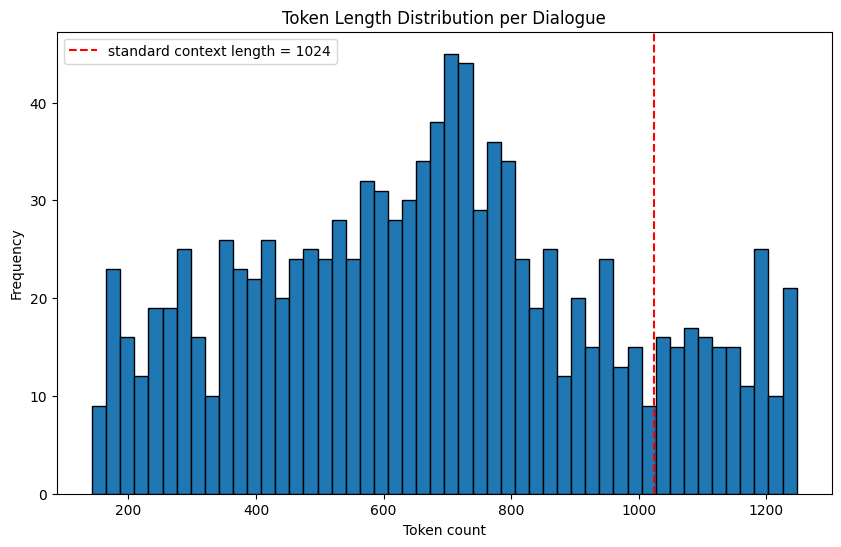

In [24]:
show_histo(filtered_lengths)

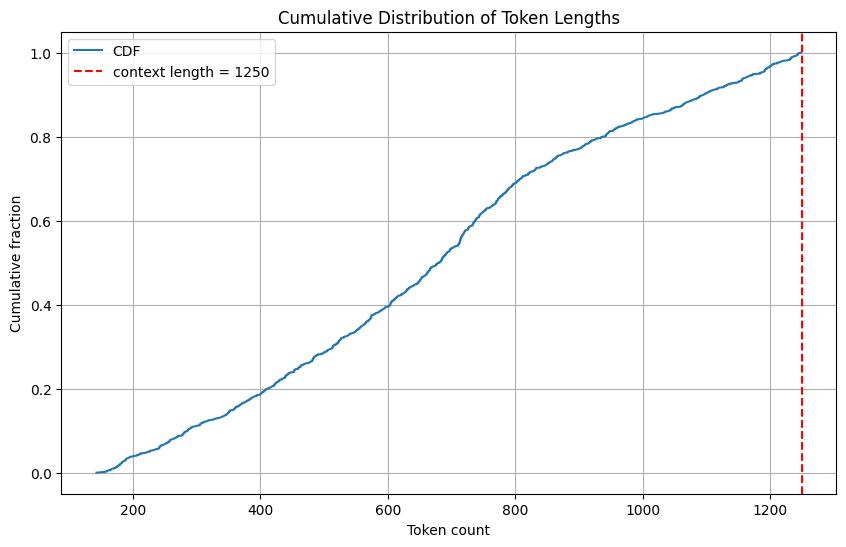

In [25]:
show_cdf(final_context_length, filtered_lengths)

In [26]:
dataset

Dataset({
    features: ['dialogue', 'source', 'num_tokens_unpadded', 'formatted_conversation'],
    num_rows: 1109
})

In [27]:
# Split merged dataset into train/validation again
train_data = dataset.filter(lambda x: x["source"] == "train")
val_data = dataset.filter(lambda x: x["source"] == "test")

Filter:   0%|          | 0/1109 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1109 [00:00<?, ? examples/s]

In [28]:
from datasets import DatasetDict

raw_datasets = DatasetDict(
    {
        "train": train_data,
        "val": val_data,
    }
)

In [29]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'source', 'num_tokens_unpadded', 'formatted_conversation'],
        num_rows: 970
    })
    val: Dataset({
        features: ['dialogue', 'source', 'num_tokens_unpadded', 'formatted_conversation'],
        num_rows: 139
    })
})

## To fine-tune an LLM we need to convert the conversations into a specific format. 
The following codeblock describes the chat template of the LLama Models. Sequences that are not of the same length are padded with the special token <|finetune_right|>. Every sequence needs to be of the same lengths for the model to learn from the training data.
```
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
Background/Context of the Conversation and the scene
<|eot_id|>

<|start_header_id|>Name of Character 1<|end_header_id|>
Utterance of Character 1 
<|eot_id|>

<|start_header_id|>Name of Character 2<|end_header_id|>
Utterance of Character 2
<|eot_id|>

<|end_of_text|>
```
    

| Token         |  Placement            | What does this token indicate?                                             | Where to use the token?             |
|---------------|  -------------------- |----------------------------------------------------------------------------|-------------------------------------|
| <\|begin\_of\_text\|> |  Begin of text        | Signals the **start** of the training sample                               | **Very first token**                |
| <\|start\_header\_id\|> |  Start of role header | Starts a **speaker block** (e.g., system, user, assistant, or custom role) | **Before role name**                |
| <\|end\_header\_id\|> |  End of role header   | Ends the speaker role tag                                                  | **After role name**                 |
| <\|eot\_id\|> |  End of turn          | Marks the **end of one dialogue turn**                                     | **After every speaker’s utterance** |
| <\|end\_of\_text\|> |  End of full sequence | Signals the **end of the entire dialogue example**                         | **At the very end of each sample**  |

For Gwen and Mistral there are other templates. Most of the time the respective tokenizer for the chosen model fro huggingface will be able to format the conversations accordingly.

In [30]:
raw_datasets["train"][0]["formatted_conversation"]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 03 Dec 2025\n\nYou are Harry Potter. Never break character. All dialogue must be in first person, natural, and consistent with the tone of a 12-year old. If the user strays from role, redirect them firmly back.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAt the zoo, Harry is given a cheap lemon ice pop while Dudley and Piers receive large chocolate ice creams. Harry enjoys the rare treat and the outing, feeling a momentary sense of joy and normalcy. He distances himself from Dudley and Piers to avoid their bullying. The tone is slightly more relaxed for Harry, who is cautious but momentarily content, while the Dursleys remain indifferent to his enjoyment.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nYou know, there was this one time when I was at the zoo with the Dursleys. They bought Dudley and his friend Piers these massive chocolate ice creams

# Beginning fine-tuning custom model

In [31]:
train_data

Dataset({
    features: ['dialogue', 'source', 'num_tokens_unpadded', 'formatted_conversation'],
    num_rows: 970
})

In [32]:
# https://youtu.be/ma1TrR7gE7I See Data processing for Causal Language Modeling from Huggingface
# https://youtu.be/Lt7KrFMcCis
#https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/videos/clm_processing.ipynb#scrollTo=bybqwkrBQ6L7

def pad_conversations(row):
    tokenized_padded = tokenizer(
        row["formatted_conversation"],
        padding="longest", # to pad to the longest sequence in the batch (doing no padding if you only provide a single sequence). So, if we have batched=False, every row stays the same length.
        return_tensors="pt",
        return_special_tokens_mask=True
        # I do not think we need truncation here, as all sequences are under or equal to a< specified length of tokens in the variable "final_context_length"
    )
    # The labels for Causal Language Modeling are the same as the input IDs
    # We need to mask out the padding tokens in the labels so the loss function ignores them
    labels = tokenized_padded["input_ids"].clone()
    labels[labels == tokenizer.pad_token_id] = -100
    return {"input_ids": tokenized_padded["input_ids"].squeeze(0),
            "attention_mask": tokenized_padded["attention_mask"].squeeze(0),
            "labels": labels.squeeze(0)}


tokenized_train = train_data.map(
    pad_conversations,
    desc="Formatting and counting tokens",
    remove_columns=train_data.column_names, # When tokenizing or formatting text, you typically don’t need the old raw data. We therefore delete these columns.
    batched=True
)

tokenized_val = val_data.map(
    pad_conversations,
    desc="Formatting and counting tokens",
    remove_columns=val_data.column_names,
    batched=True
)

# Format for PyTorch/Trainer
tokenized_train.set_format("torch")
tokenized_val.set_format("torch")

# Confirm structure
print(tokenized_train.features)

Formatting and counting tokens:   0%|          | 0/970 [00:00<?, ? examples/s]

Formatting and counting tokens:   0%|          | 0/139 [00:00<?, ? examples/s]

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [33]:
tokenized_train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 970
})

In [34]:
tokenized_train.features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [35]:
# Now, every element in one batch, should be the same size - the size of the longest sequence in the batch.
len(tokenized_train[8]["input_ids"])

1244

In [36]:
tokenized_train[8]["input_ids"]

tensor([128004, 128004, 128004,  ...,  32078,     13, 128009])

In [37]:
# Using the LLama Models, we should see leading padding tokens with the ID 128004 on the left (beginning) of the tensor.
tokenized_train[19]["input_ids"]

tensor([128004, 128004, 128004,  ...,    757,     13, 128009])

In [38]:
# These padding tokens are being masked out while training and are marked with -100.
tokenized_train[19]["labels"]

tensor([  -100,   -100,   -100,  ...,    757,     13, 128009])

## What is a DataCollator?
Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of `train_dataset` or `eval_dataset`.
To be able to build batches, data collators may apply some processing (like padding). Some of them (like `DataCollatorForLanguageModeling`) also apply some random data augmentation (like random masking) on the formed batch.


In [39]:
#from transformers import DataCollatorWithPadding
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # not masked LM — we are doing causal LM
)

## Causal Language Modeling
Causal language modeling is the task of predicting the token following a sequence of tokens. In this situation, the model only attends to the left context (tokens on the left of the mask). Such a training is particularly interesting for generation tasks.

In [40]:
import torch
from peft import get_peft_model, LoraConfig, TaskType
from transformers import Conv1D, AutoModelForCausalLM

def get_specific_layer_names(model):
    # Create a list to store the layer names
    layer_names = []
    
    # Recursively visit all modules and submodules
    for name, module in model.named_modules():
        # Check if the module is an instance of the specified layers
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, Conv1D)):
            # model name parsing 
            layer_names.append('.'.join(name.split('.')[4:]).split('.')[0])
    return layer_names

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name, 
    token=True,
    device_map="auto",
    #dtype="auto"
)

In [41]:
tokenizer.pad_token

'<|finetune_right_pad_id|>'

In [42]:
base_model.config.pad_token_id

128004

In [43]:
base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.config.eos_token_id = tokenizer.eos_token_id

In [44]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [45]:
list(set(get_specific_layer_names(base_model)))

['',
 'gate_proj',
 'down_proj',
 'k_proj',
 'o_proj',
 'up_proj',
 'q_proj',
 'v_proj']

In [46]:
len(tokenizer)

128256

In [47]:
print("Original tokenizer vocab size:")
print(base_model.config)

Original tokenizer vocab size:
LlamaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "unsloth_fixed": true,
  "use_cache": true,
  "vocab_size": 128256
}



In [48]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,   # Type of task -> Causal Language Modeling (predict next token based on previous tokens, GPT-style models)
    r=64,                            # Rank of the low-rank adaptation matrices (controls adapter size,  capacity and how many parameters are trainable). Most of the time 8,16,32,64 etc. With larger models this can also be up to 256
    lora_alpha=128,                  # Scaling factor applied to the LoRA weights (effective update = alpha / r). This value should/can be set to double the r value -> lora_alpha = r * 2. This obviously needs a lot of VRAM.
    lora_dropout=0.05,                  # Dropout probability for the LoRA layers (0 = no dropout)
    bias="none",                     # Whether to train bias terms: "none", "all", or "lora_only"
    target_modules=[                 # List of layers where LoRA adapters are injected:
        'k_proj',                    # Key projection in attention
        'up_proj',                   # Feed-forward "up" projection
        'down_proj',                 # Feed-forward "down" projection
        'v_proj',                    # Value projection in attention
        'o_proj',                    # Output projection in attention
        'q_proj',                    # Query projection in attention
        'gate_proj'                  # Gating projection in feed-forward networks
    ],
)
lora_model = get_peft_model(base_model, lora_config)

In [49]:
lora_model.print_trainable_parameters()

trainable params: 45,088,768 || all params: 1,280,903,168 || trainable%: 3.5201


In [50]:
print(f"CUDA is available?: {torch.cuda.is_available()}") 
print(f"How many devices are available?: {torch.cuda.device_count()}") 
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  Memory allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")
    print(f"  Memory reserved:  {torch.cuda.memory_reserved(i)/1024**3:.2f} GB")
    print(f"  Memory free:      {(torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_allocated(i))/1024**3:.2f} GB\n")

CUDA is available?: True
How many devices are available?: 1
GPU 0: NVIDIA GeForce RTX 4090
  Memory allocated: 4.77 GB
  Memory reserved:  5.66 GB
  Memory free:      19.22 GB



In [54]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuning/rope_model_checkpoints_and_pred",
    per_device_train_batch_size=4,  # If there is enough VRAM we can just put our desired batch size here.   
    gradient_accumulation_steps=8,  # If GPU memory is limited, we advise using gradient accumulation to simulate larger batch sizes. For example, using a per-device batch size of 4 and gradient accumulation steps of 8 results in an effective batch size of 32 .
    bf16=False,                      # native H100 bf16 --> Onmly important if we train using high end GPUs
    fp16=False,
    dataloader_drop_last=True, # supposed to drop loss spikes during training.
    num_train_epochs=100, # How often the model sees the complete training data, can be high because of early stopping mechanism
    eval_strategy="steps",
    no_cuda=False,
    logging_steps=25,                     
    logging_strategy="steps",            
    save_strategy="steps",
    report_to="none",
    learning_rate=2e-4, #2e-4 was initially planned. Can be reset war auch mal 1e-5
    warmup_ratio=0.05, #
    #['adamw_torch', 'adamw_torch_fused', 'adamw_torch_xla', 'adamw_torch_npu_fused', 'adamw_apex_fused', 'adafactor', 'adamw_anyprecision', 'adamw_torch_4bit', 'adamw_torch_8bit', 'ademamix', 'sgd', 'adagrad', 'adamw_bnb_8bit', 'adamw_8bit', 'ademamix_8bit', 'lion_8bit', 'lion_32bit', 'paged_adamw_32bit', 'paged_adamw_8bit', 'paged_ademamix_32bit', 'paged_ademamix_8bit', 'paged_lion_32bit', 'paged_lion_8bit', 'rmsprop', 'rmsprop_bnb', 'rmsprop_bnb_8bit', 'rmsprop_bnb_32bit', 'galore_adamw', 'galore_adamw_8bit', 'galore_adafactor', 'galore_adamw_layerwise', 'galore_adamw_8bit_layerwise', 'galore_adafactor_layerwise', 'lomo', 'adalomo', 'grokadamw', 'schedule_free_radam', 'schedule_free_adamw', 'schedule_free_sgd', 'apollo_adamw', 'apollo_adamw_layerwise', 'stable_adamw'
    optim = "adamw_8bit", #adamw_8bit, Kann man den anders machen? Sind die 8Bit nicht sinnvoll bei bf16?
    weight_decay = 0.1,
    lr_scheduler_type = "cosine",
    label_names=["input_ids"],
    seed=3407,
    #dataloader_num_workers=4,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Metric for when Early Stopping happens
    greater_is_better=False,            # because lower loss is better
)


In [55]:
from transformers import TrainerCallback

class UnifiedEarlyStoppingCallback(TrainerCallback):
    def __init__(self, 
                 train_patience=200, 
                 eval_patience=3,
                 min_delta=1e-4):
        
        self.train_patience = train_patience
        self.eval_patience = eval_patience
        self.min_delta = min_delta
        
        self.best_train_loss = float("inf")
        self.train_counter = 0

        self.best_eval_loss = float("inf")
        self.eval_counter = 0

    # ---------------------------
    # TRAIN LOSS CHECKING
    # ---------------------------
    def _get_latest_train_loss(self, state):
        # Look at the most recent log entries for 'loss'
        for entry in reversed(state.log_history):
            if "loss" in entry:
                return entry["loss"]
        return None

    # ---------------------------
    # EVAL LOSS CHECKING
    # ---------------------------
    def _get_latest_eval_loss(self, logs):
        if logs is None:
            return None
        return logs.get("eval_loss", None)

    # ---------------------------
    # MAIN CALLBACK
    # ---------------------------
    def on_log(self, args, state, control, logs=None, **kwargs):
        stop_training = False
        
        # ======== TRAINING LOSS ========
        train_loss = self._get_latest_train_loss(state)
        if train_loss is not None:
            if (self.best_train_loss - train_loss) > self.min_delta:
                self.best_train_loss = train_loss
                self.train_counter = 0
            else:
                self.train_counter += 1

            if self.train_counter >= self.train_patience:
                print("\n🚨 Early Stop: Training loss stagnated!")
                stop_training = True

        # ======== VALIDATION LOSS ========
        eval_loss = self._get_latest_eval_loss(logs)
        if eval_loss is not None:
            # Only run this branch DURING evaluation logs
            if (self.best_eval_loss - eval_loss) > self.min_delta:
                self.best_eval_loss = eval_loss
                self.eval_counter = 0
            else:
                self.eval_counter += 1

            if self.eval_counter >= self.eval_patience:
                print("\n🚨 Early Stop: Validation loss increased!")
                stop_training = True

        # ======== APPLY CONTROL ========
        if stop_training:
            control.should_training_stop = True

        return control


In [56]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    callbacks=[UnifiedEarlyStoppingCallback(
        train_patience=200,
        eval_patience=2,
        min_delta=1e-4
    )]
)

In [57]:
trainer.train(resume_from_checkpoint=False)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# trainer = your Trainer instance

# Extract logged metrics
logs = trainer.state.log_history
df = pd.DataFrame(logs)

window = 2
# Training loss
train_df = df[df["loss"].notnull()].copy()
train_df["smoothed_loss"] = train_df["loss"].rolling(window=window).mean()

# Validation loss
eval_df = df[df["eval_loss"].notnull()].copy()
eval_df["smoothed_eval_loss"] = eval_df["eval_loss"].rolling(window=window).mean()

# Plot
plt.figure(figsize=(10, 5))

# Training
plt.plot(train_df["step"], train_df["loss"], label="Raw Training Loss", alpha=0.3, marker='o')
plt.plot(train_df["step"], train_df["smoothed_loss"], label="Smoothed Training Loss", linewidth=2)

# Validation
plt.plot(eval_df["step"], eval_df["eval_loss"], label="Raw Validation Loss", alpha=0.3, marker='x')
plt.plot(eval_df["step"], eval_df["smoothed_eval_loss"], label="Smoothed Validation Loss", linewidth=2)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
trainer.evaluate()

In [ ]:
from pathlib import Path
rope_model_finetuned = Path("./finetuning/finetuned_model")
merged_model_dir = Path("./finetuning/merged_model")
base_model_dir = Path("./finetuning/base_model_dir")
checkpoint_final = Path("./finetuning/rope_model_checkpoints_and_pred")
trainer_save = Path("./finetuning/trainer_model")

In [ ]:
# Save the fine-tuned LoRA adapter
lora_model.save_pretrained(rope_model_finetuned)

# Save the tokenizer
tokenizer.save_pretrained(rope_model_finetuned)

# (Optional) Save the base model for reproducibility
base_model.save_pretrained(base_model_dir)

In [ ]:
import os

print("cwd:", repr(os.getcwd()))
print("repr:", repr(str(rope_model_finetuned)))
print("as_posix:", rope_model_finetuned.as_posix())
print("exists:", rope_model_finetuned.exists())
print("is dir:", rope_model_finetuned.is_dir())
print("abs path:", rope_model_finetuned.resolve())


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel


# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(base_model_dir)

# Load the adapter on top
lora_model = PeftModel.from_pretrained(base_model, rope_model_finetuned)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(rope_model_finetuned)

lora_model.to("cuda")

In [ ]:
merged_model = lora_model.base_model.merge_adapter()
merged_model.save_pretrained(merged_model_dir)
tokenizer.save_pretrained(merged_model_dir)

In [ ]:
introduction = """HERE CURRENT SITUATION HARRY IS IN"""

In [ ]:

conversation = [{"role": "system", "content": system_prompt_harry},
                {"role": "assistant", "content": introduction},
                {"role": "user", "content": "Hello Harry how are you feeling today?"},
                ]

In [ ]:
formatted_conversation = tokenizer.apply_chat_template(conversation,
                                                              tokenize=True,
                                                              add_generation_prompt=True,
                                                              return_tensors="pt"
                                                              # For training this is set to false. While inference this is set to true. 
                                                              ).to(lora_model.device)

In [ ]:
formatted_conversation

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(merged_model)
tokenizer = AutoTokenizer.from_pretrained(merged_model)

outputs = model.generate(
    formatted_conversation,
    max_new_tokens=500,
    temperature=0.7,
    repetition_penalty=1.2,
    do_sample=True,
    top_p=0.9,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id
)

# Decode and print
print(tokenizer.decode(outputs[0], skip_special_tokens=False))

In [ ]:
outputs

## Evaluation Setup

Model performance will be evaluated through a **controlled comparison**: for each test event, both **GPT-5 (Web)** and the **fine-tuned local model** received the *same system prompt* and *identical event context*.
Their outputs will then be compared along three qualitative criteria:

1. **Coherence** – Does the response maintain a logical narrative flow, emotional progression, and consistent conversational structure?

2. **Faithfulness to Character** – Does the model reproduce the expected behavioral, emotional, and stylistic patterns of the target persona?

3. **Naturalness** – Does the dialogue feel human-like and appropriately constrained to the fictional character, rather than broad or omniscient?